In [149]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Read in data

In [104]:
traindf = pd.read_csv('../input/train.csv')
traindf['Date'] = pd.to_datetime(traindf.Date)
traindf['Yr'] = traindf.Date.dt.year 
traindf['Day'] = traindf.Date.dt.dayofyear
traindf.set_index('Date')

# just use 2007 for first pass
traindf07 = traindf[(traindf.Date>'2007-01-01') & (traindf.Date<'2007-10-10')]

In [24]:
plt.rcParams['figure.figsize'] = (14,6)
plt.style.use('fivethirtyeight')

# Exploration

## Westnile vs. time
Aggregate by week or day? First want to aggregate by day, then we can smooth or whatever

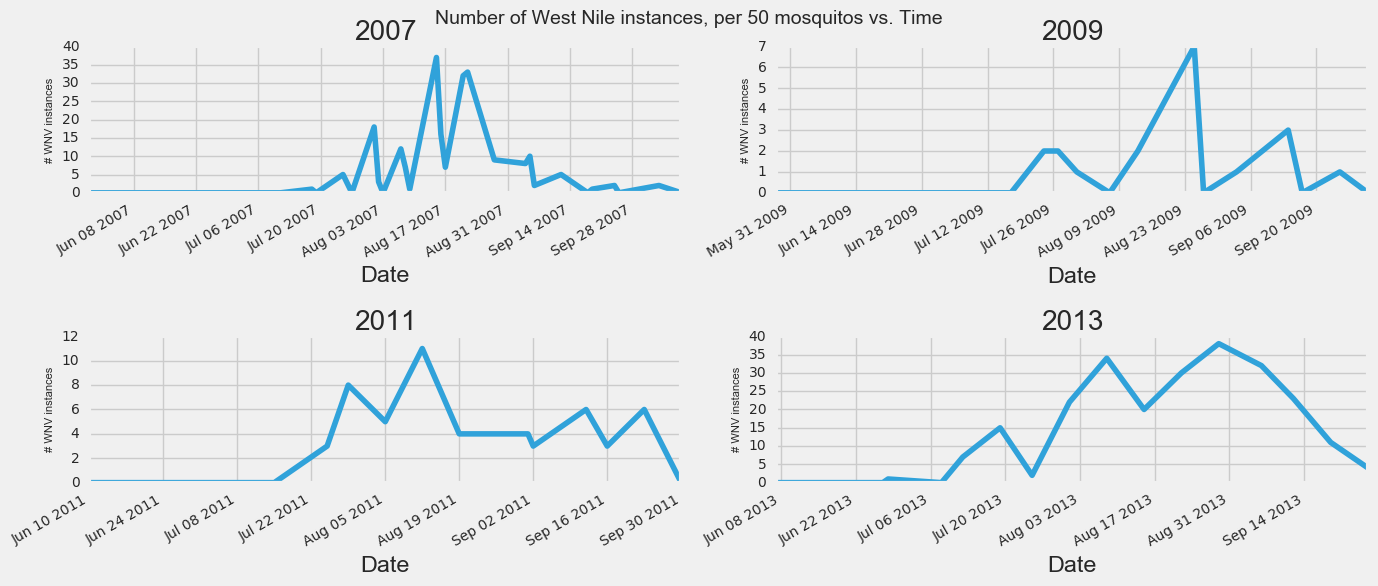

In [102]:
for i,(yr,_df) in enumerate(traindf.groupby('Yr')):
    plt.subplot(2,2,i+1)
    wnv_sum = _df.groupby('Date')['WnvPresent'].sum()
    wnv_sum.plot()
    plt.title(yr)
    plt.tight_layout()
    plt.ylabel("# WNV instances", size = 8)
plt.suptitle('Number of West Nile instances, per 50 mosquitos vs. Time')


## Total number of mosquitos

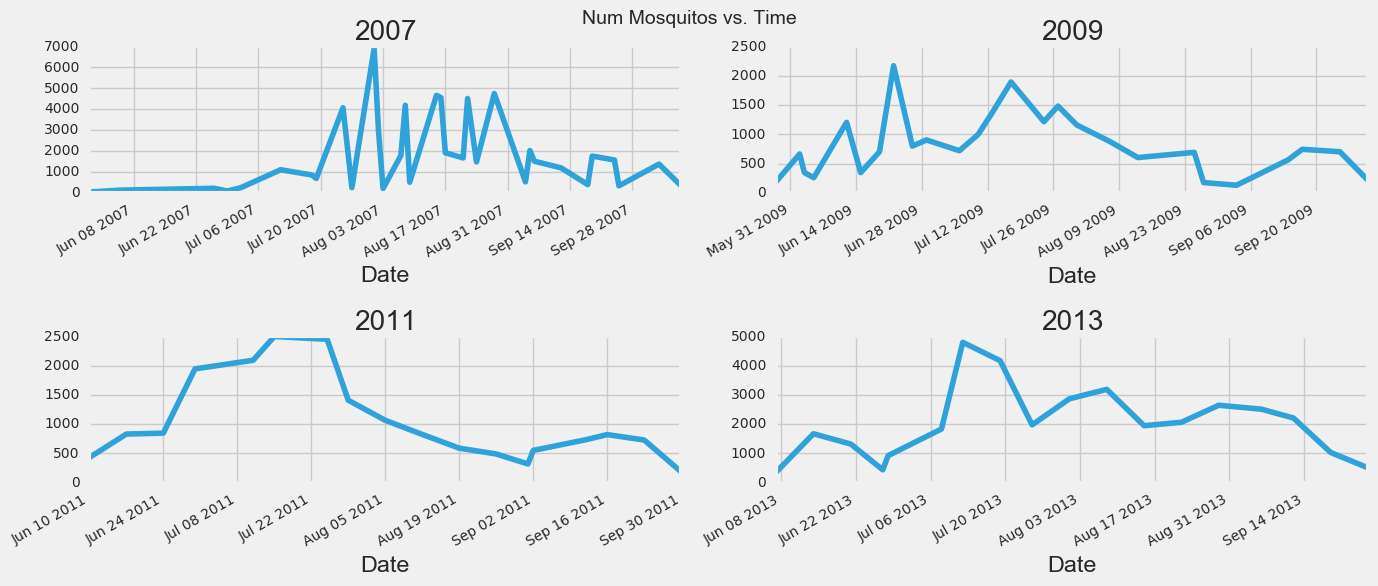

In [25]:
for i,(yr,_df) in enumerate(traindf.groupby('Yr')):
    plt.subplot(2,2,i+1)
    wnv_sum = _df.groupby('Date')['NumMosquitos'].sum()
    wnv_sum.plot()
    plt.title(yr)
    plt.tight_layout()
plt.suptitle('Num Mosquitos vs. Time')

# Group station to presence of WNV

In [70]:
_ = traindf.groupby(['Day','Trap'])#['WnvPresent'].max()
sta_df = _.aggregate({'WnvPresent':'max','Longitude':'max','Latitude':'max'})
sta_df = sta_df.reset_index()

In [83]:
X = sta_df[['Day','Trap','Longitude','Latitude']]
X = pd.get_dummies(X)
y = sta_df['WnvPresent']

In [84]:
from sklearn.cross_validation import train_test_split
Xtrain,Xtest,ytrain,ytest= train_test_split(X,y,test_size = 0.2, random_state = 4)

In [85]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier()
cl.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc,roc_auc_score,roc_curve
cld = DummyClassifier(strategy = 'most_frequent')
cld.fit(Xtrain,ytrain)

d_yprob = cld.predict_proba(Xtest)[:,1]
print(roc_auc_score(ytest, d_yprob))

yprob = cl.predict_proba(Xtest)[:,1]
print(roc_auc_score(ytest, yprob))


cld.score(Xtest,ytest)
# cl.score(Xtest,ytest)

0.5
0.697006703273


0.91105769230769229

AUC: 0.697006703273


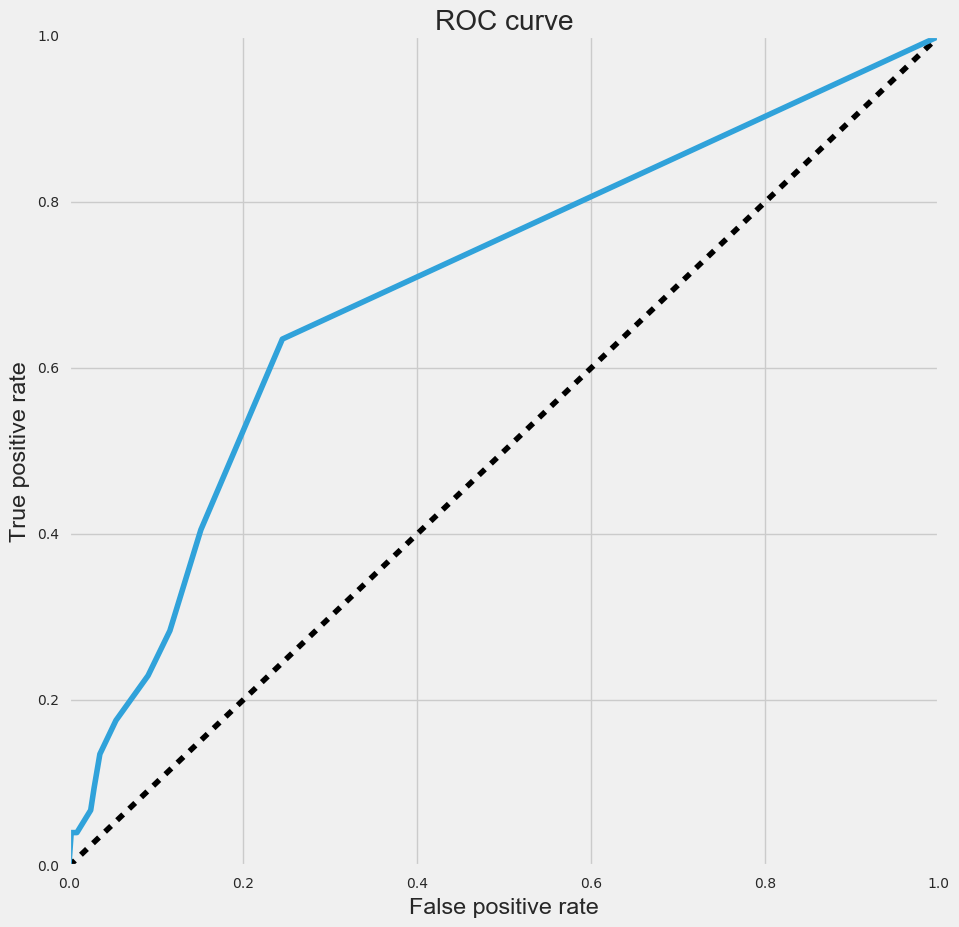

In [98]:
def plot_roc(ytest, ypred_prob):
    print "AUC: {}".format(roc_auc_score(ytest, ypred_prob))
    fpr, tpr, _ = roc_curve(ytest, ypred_prob)
    plt.figure(1,figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

plot_roc(ytest, yprob)

# Mosquito frequency
Want to see in training data, how much we see of each type of mosquito, can plot behaviour over time

In [232]:
plt.rcParams['axes.color_cycle']

/Users/crawles/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


[u'#30a2da', u'#fc4f30', u'#e5ae38', u'#6d904f', u'#8b8b8b']

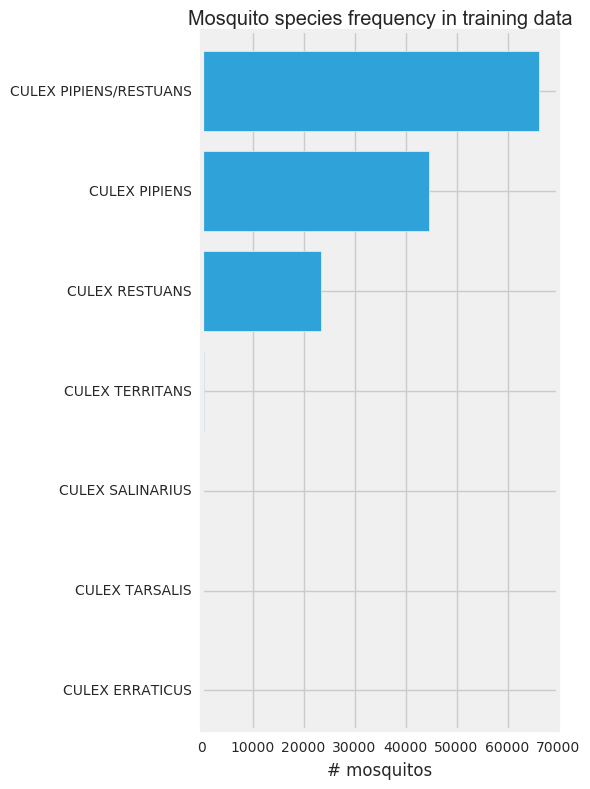

In [248]:
df = traindf.groupby('Species').aggregate({'NumMosquitos':'sum'})
vc = pd.Series(df.NumMosquitos).sort_values(ascending=False)
def plot_mosquito_freq(vc,**plotargs):
    fig = plt.figure(figsize = (6,8))
    ax = fig.add_subplot(111)
    loc = np.arange(len(vc))
    height = .8
    ax.barh(loc,vc[::-1], height = height,**plotargs)
    ax.set_yticks(loc + height/2)
    ax.set_yticklabels(vc.index[::-1])
    return ax
ax = plot_mosquito_freq(vc,**{'color':'#30a2da'})
plt.xlabel('# mosquitos')
plt.title('Mosquito species frequency in training data')
plt.tight_layout()
plt.savefig('../results/{}.png'.format(ax.get_title()))

ax.get_title()

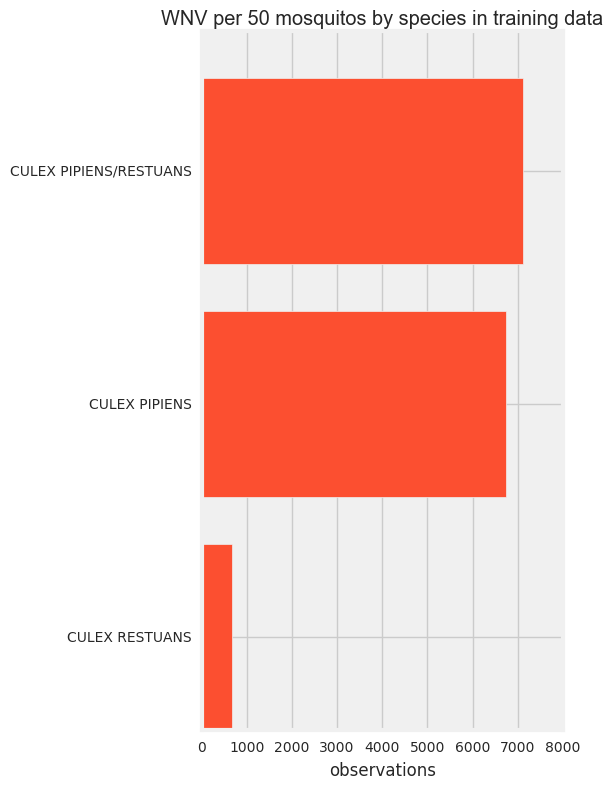

In [247]:
query_str = "WnvPresent == 1"
df = traindf.\
     query(query_str).\
     groupby('Species').\
     aggregate({'NumMosquitos':'sum'})
vc = pd.Series(df.NumMosquitos).sort_values(ascending=False)
ax = plot_mosquito_freq(vc,**{'color':'#fc4f30'})
plt.title('WNV per 50 mosquitos by species in training data')
plt.xlabel('observations')
plt.tight_layout()
plt.savefig('../results/{}.png'.format(ax.get_title()))

In [238]:
**{'color':'#fc4f30'}

SyntaxError: invalid syntax (<ipython-input-238-5e8ccdc010ee>, line 1)

In [194]:
traindf.shape

(10506, 14)

# Model2 - Now using mosquito type